<a href="https://colab.research.google.com/github/Guilherm0/Clustering/blob/main/ClusteringDinamica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 : Business Understanding

Um e-commerce do Reino Unido contratou os alunos da DNC para agruparem seus clientes com base nas métricas RFM (discutidas abaixo), para então definir estratégias de fidelização. 

RFM:
- R (Recency): Tempo que o cliente realizou a última compra (em dias)
- F (Frequency): Quantidade de compras realizadas pelo cliente
- M (Monetary): Valor do **ticket médio** gasto pelo cliente


O conjunto de dados fornecido contém transações ocorridas entre dezembro de 2010 e dezembro de 2011.

Seu objetivo é clusterizar os clientes com base em suas métricas de RFM.

Fonte do dataset [neste link](https://www.kaggle.com/datasets/carrie1/ecommerce-data).

# Step 2 : Data Understanding

## Setup

In [ ]:
%%capture
%pip install sidetable

In [ ]:
import numpy as np
import pandas as pd
import sidetable

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, scale
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering, estimate_bandwidth
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer

In [ ]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

## Dataset

In [ ]:
df = pd.read_csv('ecommerce.csv', sep=';', encoding='latin1')
print(df.shape)
df.head()

(25832, 7)


,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,06/06/2021 08:26,6,2.55,17850.0,16/08/2021
1,536366,HAND WARMER UNION JACK,06/06/2021 08:28,6,1.85,17850.0,16/08/2021
2,536367,ASSORTED COLOUR BIRD ORNAMENT,06/06/2021 08:34,32,1.69,13047.0,14/05/2022
3,536368,JAM MAKING SET WITH JARS,06/06/2021 08:34,6,4.25,13047.0,14/05/2022
4,536369,BATH BUILDING BLOCK WORD,06/06/2021 08:35,3,5.95,13047.0,14/05/2022


## Data understanding

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25832 entries, 0 to 25831
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_pedido       25832 non-null  object 
 1   descricao       24378 non-null  object 
 2   data_pgto       25832 non-null  object 
 3   quantidade      25832 non-null  int64  
 4   preco_unitario  25832 non-null  float64
 5   id_cliente      22190 non-null  float64
 6   ultima_compra   25832 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.4+ MB


In [ ]:
df[['descricao']].nunique()

descricao    3003
dtype: int64

In [ ]:
df.isna().sum()

id_pedido            0
descricao         1454
data_pgto            0
quantidade           0
preco_unitario       0
id_cliente        3642
ultima_compra        0
dtype: int64

In [ ]:
df.stb.missing()

,missing,total,percent
id_cliente,3642,25832,14.098792
descricao,1454,25832,5.628678
id_pedido,0,25832,0.000000
data_pgto,0,25832,0.000000
quantidade,0,25832,0.000000
preco_unitario,0,25832,0.000000
ultima_compra,0,25832,0.000000


In [ ]:
df[df.id_cliente.isna()]

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
46,536414,NaN,06/06/2021 11:52,56,0.00,NaN,#N/D
89,536544,DECORATIVE ROSE BATHROOM BOTTLE,06/06/2021 14:32,1,2.51,NaN,#N/D
90,536545,NaN,06/06/2021 14:32,1,0.00,NaN,#N/D
91,536546,NaN,06/06/2021 14:33,1,0.00,NaN,#N/D
92,536547,NaN,06/06/2021 14:33,1,0.00,NaN,#N/D
...,...,...,...,...,...,...,...
25748,581435,4 SKY BLUE DINNER CANDLES,13/06/2022 16:14,1,1.25,NaN,#N/D
25752,581439,IVORY WICKER HEART SMALL,13/06/2022 16:30,4,1.25,NaN,#N/D
25800,581492,SET 36 COLOUR PENCILS LOVE LONDON,14/06/2022 10:03,2,2.46,NaN,#N/D
25805,581497,WOODLAND CHARLOTTE BAG,14/06/2022 10:23,33,2.46,NaN,#N/D


In [ ]:
df.describe()

,quantidade,preco_unitario,id_cliente
count,25832.000000,25832.000000,22190.000000
mean,19.338805,21.942417,15238.498738
std,29.457949,434.435598,1733.149624
min,1.000000,-11062.060000,12346.000000
25%,2.000000,1.060000,13755.000000
50%,8.000000,2.080000,15136.000000
75%,24.000000,4.950000,16746.000000
max,151.000000,38970.000000,18287.000000


In [ ]:
df[df.preco_unitario.le(0)]

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
46,536414,NaN,06/06/2021 11:52,56,0.0,NaN,#N/D
90,536545,NaN,06/06/2021 14:32,1,0.0,NaN,#N/D
91,536546,NaN,06/06/2021 14:33,1,0.0,NaN,#N/D
92,536547,NaN,06/06/2021 14:33,1,0.0,NaN,#N/D
94,536549,NaN,06/06/2021 14:34,1,0.0,NaN,#N/D
...,...,...,...,...,...,...,...
25650,581226,missing,13/06/2022 09:56,16,0.0,NaN,#N/D
25658,581234,NaN,13/06/2022 10:33,27,0.0,NaN,#N/D
25719,581406,POLYESTER FILLER PAD 45x45cm,13/06/2022 13:58,33,0.0,NaN,#N/D
25721,581408,NaN,13/06/2022 14:06,20,0.0,NaN,#N/D


# Step 3 : Data Preparation

Missing values

In [ ]:
df.stb.missing()

,missing,total,percent
id_cliente,3642,25832,14.098792
descricao,1454,25832,5.628678
id_pedido,0,25832,0.000000
data_pgto,0,25832,0.000000
quantidade,0,25832,0.000000
preco_unitario,0,25832,0.000000
ultima_compra,0,25832,0.000000


In [ ]:
df_na = df.isna().sum().sort_values(ascending=False).to_frame('missing_count')
df_na['missing_pct'] = df_na.missing_count.div(df.shape[0])
df_na.style.format('{:.2%}', subset='missing_pct')

,missing_count,missing_pct
id_cliente,3642,14.10%
descricao,1454,5.63%
id_pedido,0,0.00%
data_pgto,0,0.00%
quantidade,0,0.00%
preco_unitario,0,0.00%
ultima_compra,0,0.00%


In [ ]:
df.dropna(subset=['id_cliente'], inplace=True)

In [ ]:
df.stb.missing()

,missing,total,percent
id_pedido,0,22190,0.0
descricao,0,22190,0.0
data_pgto,0,22190,0.0
quantidade,0,22190,0.0
preco_unitario,0,22190,0.0
id_cliente,0,22190,0.0
ultima_compra,0,22190,0.0


Duplicados

In [ ]:
df.duplicated().sum()

0

In [ ]:
%%timeit
pd.to_datetime(df.data_pgto)

1.94 s ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
pd.to_datetime(df.data_pgto, format='%d/%m/%Y %H:%M')

60.9 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
df['id_cliente'] = df.id_cliente.astype(int)
df['data_pgto'] = pd.to_datetime(df.data_pgto, format='%d/%m/%Y %H:%M')
df['ultima_compra'] = pd.to_datetime(df.ultima_compra, format='%d/%m/%Y')

In [ ]:
df.head()

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2021-06-06 08:26:00,6,2.55,17850,2021-08-16
1,536366,HAND WARMER UNION JACK,2021-06-06 08:28:00,6,1.85,17850,2021-08-16
2,536367,ASSORTED COLOUR BIRD ORNAMENT,2021-06-06 08:34:00,32,1.69,13047,2022-05-14
3,536368,JAM MAKING SET WITH JARS,2021-06-06 08:34:00,6,4.25,13047,2022-05-14
4,536369,BATH BUILDING BLOCK WORD,2021-06-06 08:35:00,3,5.95,13047,2022-05-14


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22190 entries, 0 to 25831
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id_pedido       22190 non-null  object        
 1   descricao       22190 non-null  object        
 2   data_pgto       22190 non-null  datetime64[ns]
 3   quantidade      22190 non-null  int64         
 4   preco_unitario  22190 non-null  float64       
 5   id_cliente      22190 non-null  int64         
 6   ultima_compra   22190 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 1.4+ MB


Valores sem sentido

In [ ]:
df['preco_unitario'].le(0).sum()

7

In [ ]:
df = df.query('preco_unitario>0')

In [ ]:
df.describe()

,quantidade,preco_unitario,id_cliente
count,22183.000000,22183.000000,22183.000000
mean,18.380066,11.989585,15238.687869
std,28.159286,293.364478,1733.152853
min,1.000000,0.010000,12346.000000
25%,2.000000,1.250000,13755.000000
50%,8.000000,2.100000,15136.000000
75%,20.000000,4.950000,16746.000000
max,151.000000,38970.000000,18287.000000


Data visualization

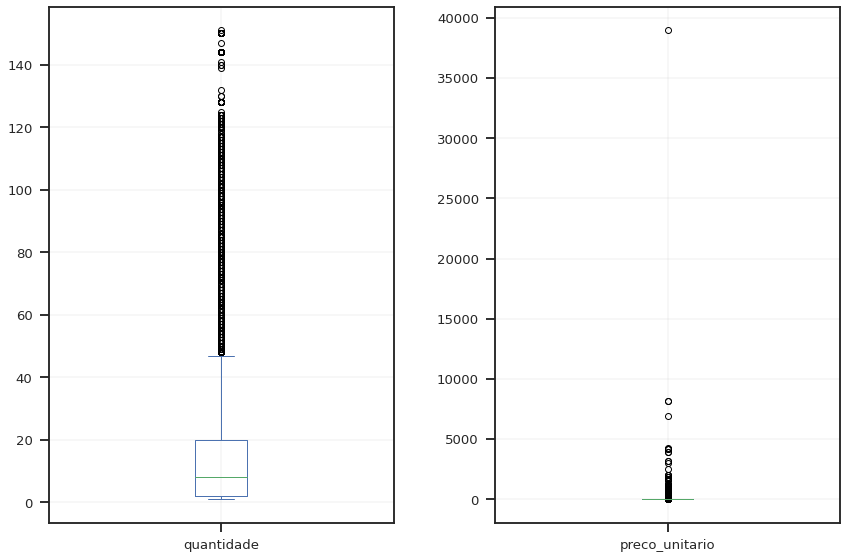

In [ ]:
df[['quantidade','preco_unitario']].plot.box(subplots=True)
plt.tight_layout(w_pad=3)
plt.show()

In [ ]:
df.query('preco_unitario > 5_000').sort_values('preco_unitario', ascending=False)

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
11509,C556445,Manual,2021-12-14 15:31:00,1,38970.00,15098,2021-12-14
8715,C551685,POSTAGE,2021-11-06 12:51:00,1,8142.75,16029,2022-05-07
8727,551697,POSTAGE,2021-11-06 13:46:00,1,8142.75,16029,2022-05-07
8729,C551699,Manual,2021-11-06 14:12:00,1,6930.00,16029,2022-05-07


In [ ]:
df = df.query('preco_unitario < 5_000')

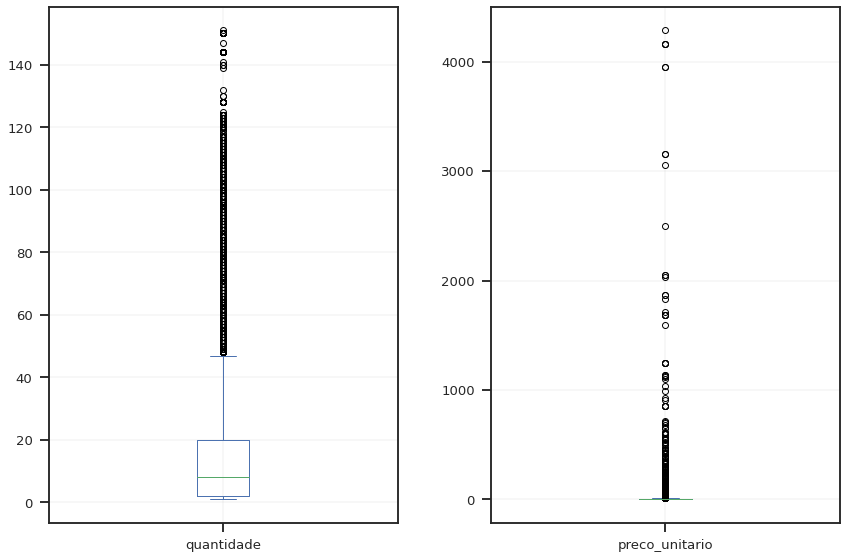

In [ ]:
df[['quantidade','preco_unitario']].plot.box(subplots=True)
plt.tight_layout(w_pad=3)
plt.show()

**Objetivo:**
- R (Recency): Tempo que o cliente realizou a última compra (Em dias)
- F (Frequency): Quantidade de compras realizadas pelo cliente
- M (Monetary): Valor do **ticket médio** gasto pelo cliente


In [ ]:
df.head()

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2021-06-06 08:26:00,6,2.55,17850,2021-08-16
1,536366,HAND WARMER UNION JACK,2021-06-06 08:28:00,6,1.85,17850,2021-08-16
2,536367,ASSORTED COLOUR BIRD ORNAMENT,2021-06-06 08:34:00,32,1.69,13047,2022-05-14
3,536368,JAM MAKING SET WITH JARS,2021-06-06 08:34:00,6,4.25,13047,2022-05-14
4,536369,BATH BUILDING BLOCK WORD,2021-06-06 08:35:00,3,5.95,13047,2022-05-14


In [ ]:
df['preco_total'] = df.preco_unitario * df.quantidade

In [ ]:
df_rfv = (
    df.groupby('id_cliente')
    .agg(
        R = ('data_pgto', lambda x: (pd.Timestamp.today() - x.max()).days),
        F = ('id_pedido', 'count'),
        V = ('preco_total', 'mean'),
    )
)

df_rfv

,R,F,V
id_cliente,,,
12346,533,2,14.040000
12347,210,7,23.308571
12348,283,4,82.840000
12349,226,1,15.000000
12350,518,1,25.200000
...,...,...,...
18280,485,1,23.700000
18281,388,1,5.040000
18282,215,3,15.166667


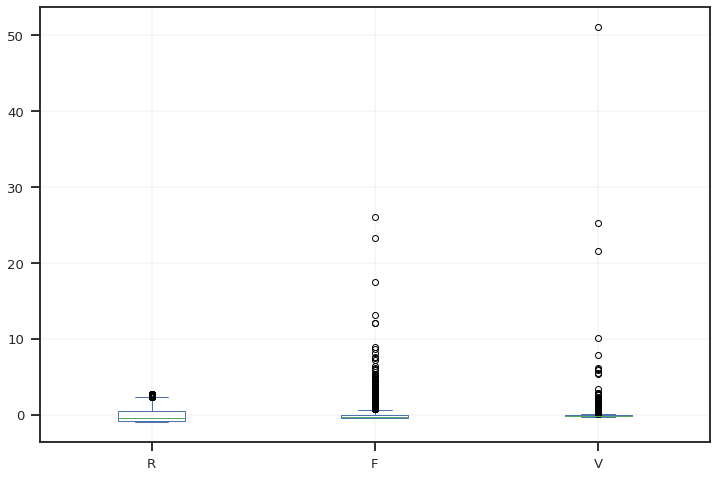

In [ ]:
df_rfv.apply(scale).plot.box()

In [ ]:
df_rfv = df_rfv[(df_rfv.apply(scale)<20).any(1)]

In [ ]:
df_rfv

,R,F,V
id_cliente,,,
12346,533,2,14.040000
12347,210,7,23.308571
12348,283,4,82.840000
12349,226,1,15.000000
12350,518,1,25.200000
...,...,...,...
18280,485,1,23.700000
18281,388,1,5.040000
18282,215,3,15.166667


In [ ]:
# # remove specific outlier
# df_rfv = df_rfv.drop(17850)

In [ ]:
df_rfv_clip = df_rfv.apply(lambda x: x.clip(upper=x.mean()+x.std()*4))

In [ ]:
df_rfv_clip

,R,F,V
id_cliente,,,
12346,533,2.0,14.040000
12347,210,7.0,23.308571
12348,283,4.0,82.840000
12349,226,1.0,15.000000
12350,518,1.0,25.200000
...,...,...,...
18280,485,1.0,23.700000
18281,388,1.0,5.040000
18282,215,3.0,15.166667


In [ ]:
df_rfv_clip_scale = df_rfv_clip.apply(scale)

In [ ]:
df_rfv_clip_scale

,R,F,V
id_cliente,,,
12346,2.316286,-0.448135,-0.353465
12347,-0.889176,0.350205,-0.209472
12348,-0.164722,-0.128799,0.715386
12349,-0.730391,-0.607803,-0.338551
12350,2.167426,-0.607803,-0.180088
...,...,...,...
18280,1.839933,-0.607803,-0.203391
18281,0.877302,-0.607803,-0.493286
18282,-0.839556,-0.288467,-0.335962


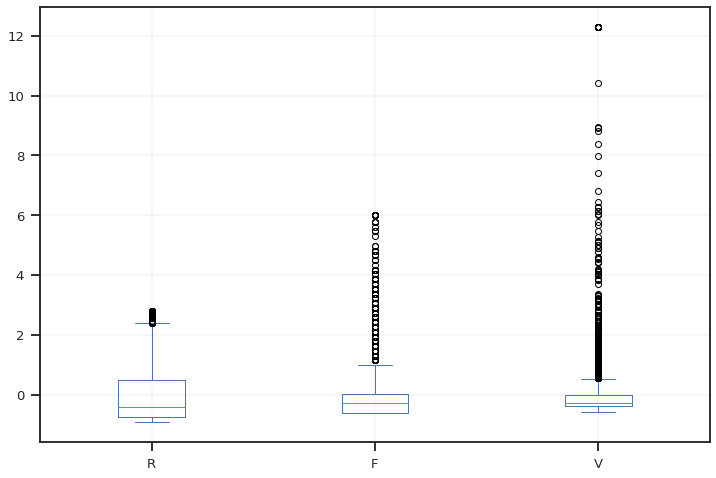

In [ ]:
df_rfv_clip_scale.plot.box();

# Step 4-5: Modeling & Model evaluation

## K-Means

Definindo melhor K:

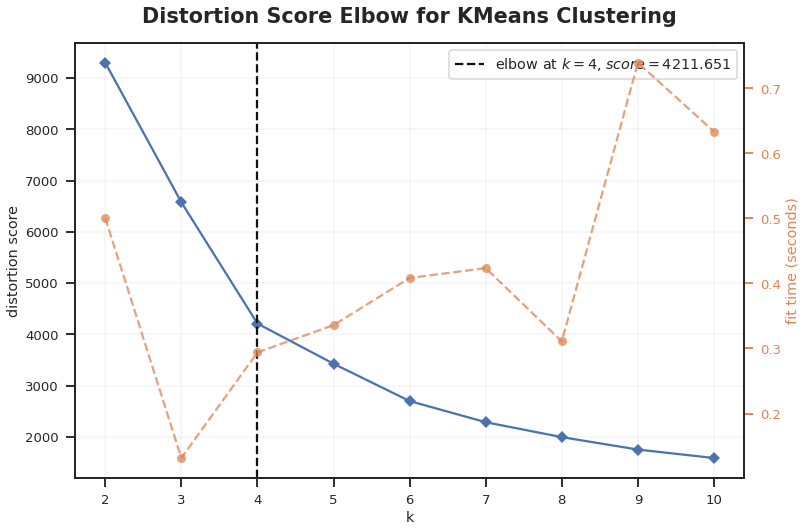

In [ ]:
kelbow_visualizer(KMeans(), df_rfv_clip_scale, k=range(2,11));

In [ ]:
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=2023)
  labels = model.fit_predict(df_rfv_clip_scale)
  cluster_results_dict = {'k':k}
  cluster_results_dict['inertia'] = model.inertia_
  
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(df_rfv_clip_scale, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient(cmap='Blues')

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,9298.980189,0.455598,0.956148,1791.966614
3,6576.890077,0.508473,0.932550,2170.458059
4,4211.718895,0.521129,0.671297,3076.499401
5,3432.138719,0.444941,0.764571,3078.751456
6,2700.085377,0.480124,0.709331,3366.738281
7,2287.678791,0.424116,0.712171,3441.749335
8,2000.371373,0.435846,0.764850,3462.533642
9,1752.726687,0.384802,0.805992,3534.065163
10,1617.659656,0.372932,0.820155,3443.328927


In [ ]:
kmeans_model = KMeans(n_clusters=4, random_state=2023)
labels = kmeans_model.fit_predict(df_rfv_clip_scale).astype(str)

px.scatter_3d(data_frame=df_rfv_clip, x='R', y='F', z='V', color=labels, template='plotly_dark')

In [ ]:
df_rfv_clip.query('R>400 & F >25')

,R,F,V
id_cliente,,,
17850,510,35.0,14.520857


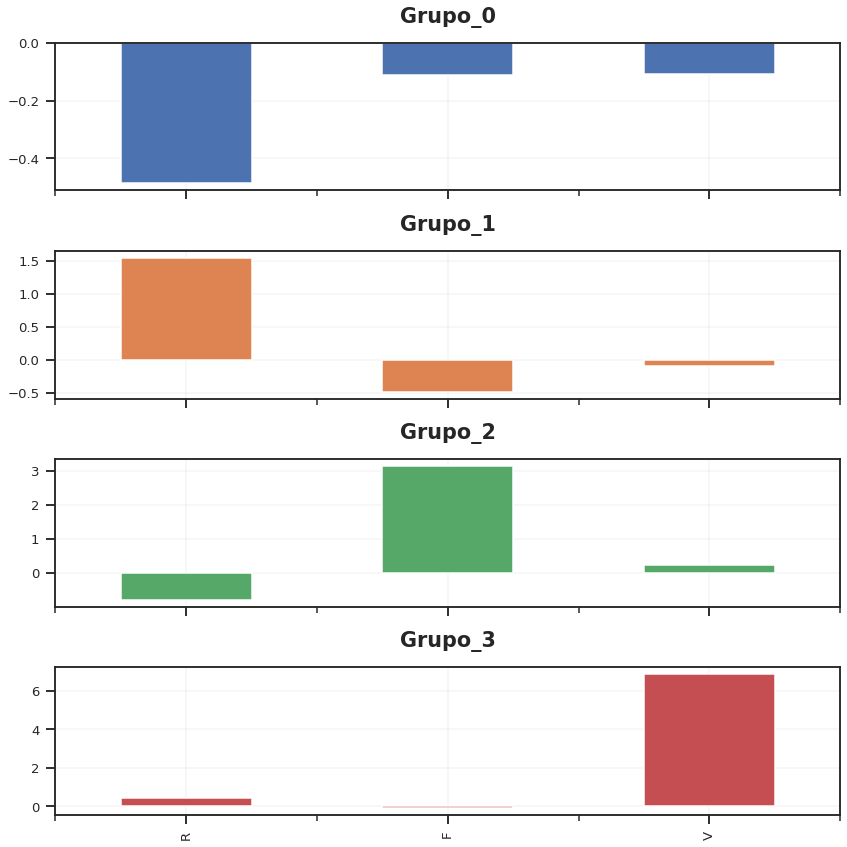

In [ ]:
pd.DataFrame(kmeans_model.cluster_centers_, columns=df_rfv_clip_scale.columns).T.add_prefix('Grupo_').plot.bar(subplots=True, figsize=(12,12), legend=False)
plt.tight_layout();

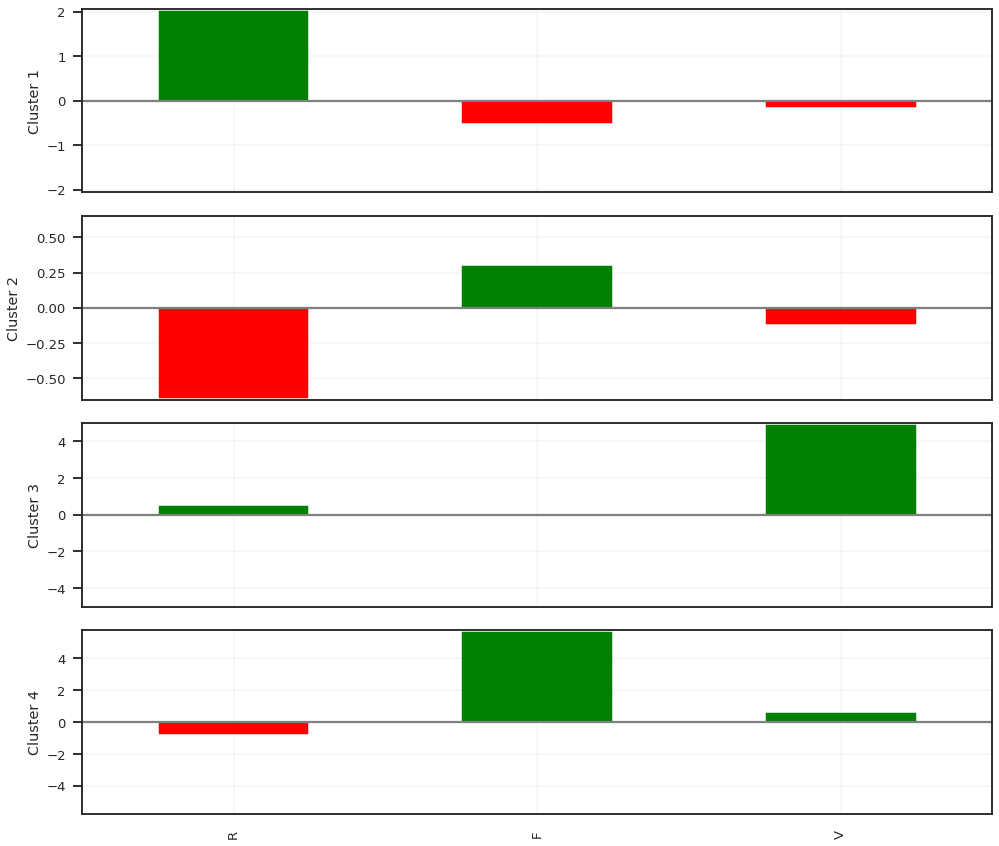

In [ ]:
# Adaptado do livro "Practical Statistics for Data Scientists"
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)
centers = pd.DataFrame(model.cluster_centers_, columns=df_rfv_clip_scale.columns)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none') 

plt.tight_layout()
plt.show()

In [ ]:
df_rfv_clip.groupby(labels).agg(['mean','size'])

R                F                 V      
         mean  size       mean  size        mean  size
0  250.537947  2991   4.124039  2991   29.921233  2991
1  455.705938  1061   1.783223  1061   30.470169  1061
2  219.782772   267  24.561574   267   52.526282   267
3  346.134615    52   4.326923    52  480.186183    52

In [ ]:
df_rfv_clip.groupby(labels).median() \
.style.background_gradient(cmap='Oranges')

,R,F,V
0,239.000000,3.000000,18.537143
1,450.000000,1.000000,17.000000
2,212.000000,21.000000,35.375333
3,335.500000,3.000000,405.423684


In [ ]:
df_rfv_clip.groupby(labels).size().to_frame('cluster_size').assign(cluster_size_pct = lambda x: x.cluster_size.div(df_rfv_clip.shape[0])) \
.style.format('{:.2%}', subset='cluster_size_pct')

,cluster_size,cluster_size_pct
0,2991,68.43%
1,1061,24.27%
2,267,6.11%
3,52,1.19%


## Hierarchical Clustering

In [ ]:
Z = linkage(df_rfv_clip_scale, method='ward')
labels = fcluster(Z, 4, criterion='maxclust')

In [ ]:
px.scatter_3d(data_frame=df_rfv_clip, x='R', y='F', z='V', color=labels, template='plotly_dark')

## DBScan

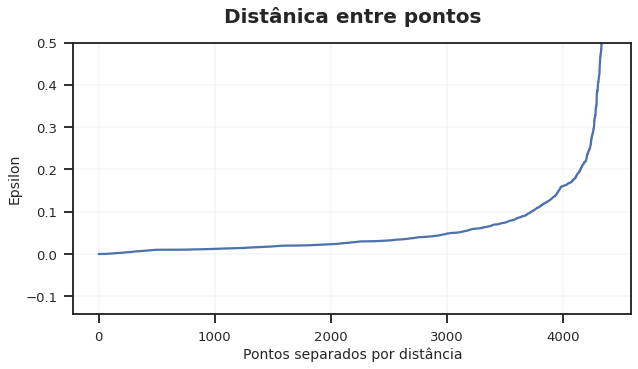

In [ ]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(df_rfv_clip_scale)

distances, indices = nbrs.kneighbors(df_rfv_clip_scale)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title('Distânica entre pontos',fontsize=20)
plt.xlabel('Pontos separados por distância',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.ylim(top=0.5)
plt.show()

In [ ]:
dbscan = DBSCAN(eps=0.25, min_samples=10)
labels = dbscan.fit_predict(df_rfv_clip_scale).astype(str)
pd.Series.value_counts(labels)

0     3856
-1     443
2       25
1       21
4       11
3       10
5        5
dtype: int64

In [ ]:
px.scatter_3d(data_frame=df_rfv_clip, x='R', y='F', z='V', color=labels, template='plotly_dark')

## Meanshift

In [ ]:
bandwidth = estimate_bandwidth(df_rfv_clip_scale)
bandwidth

1.2956732339839354

In [ ]:
model = MeanShift(bandwidth=bandwidth, n_jobs=-1)
labels = model.fit_predict(df_rfv_clip_scale).astype(str)

In [ ]:
np.unique(labels)

array(['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6',
       '7', '8', '9'], dtype='<U21')

In [ ]:
print(silhouette_score(df_rfv_clip_scale, labels))
print(davies_bouldin_score(df_rfv_clip_scale, labels))

0.4804164917391297
0.7017372825162801


In [ ]:
px.scatter_3d(data_frame=df_rfv_clip, x='R', y='F', z='V', color=labels, template='plotly_dark')

## Gaussian Mixture

In [ ]:
# Select best model by covariance type and K (Practical Statistics for Data Scientists)
results = []
k_range = range(2,11)
covariance_types = ['full', 'tied', 'diag', 'spherical']

for n_components in k_range:
  for covariance_type in covariance_types:
    mclust = GaussianMixture(n_components=n_components, warm_start=True, covariance_type=covariance_type, random_state=2023)
    mclust.fit(df_rfv_clip_scale)
    results.append({
      'bic': mclust.bic(df_rfv_clip_scale),
      'n_components': n_components,
      'covariance_type': covariance_type,
    })

results = pd.DataFrame(results)
results.sort_values('bic').head()

,bic,n_components,covariance_type
34,6387.697152,10,diag
32,6748.796101,10,full
28,6788.975373,9,full
30,6845.895974,9,diag
24,6959.535015,8,full


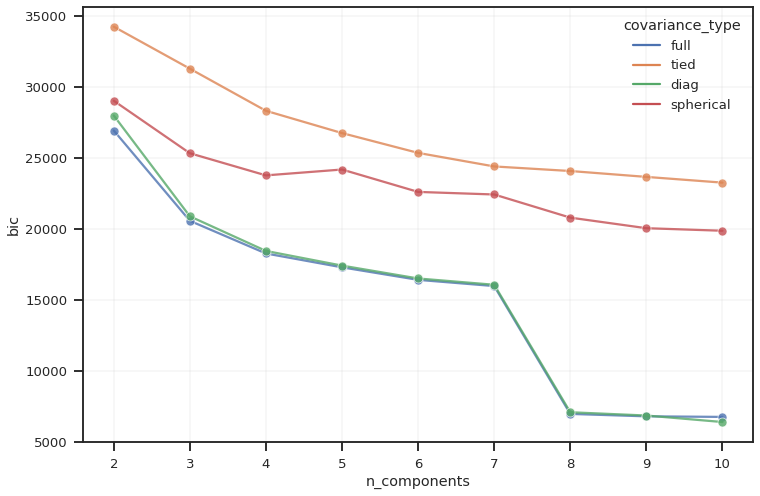

In [ ]:
# Plot
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type', marker='o', alpha=.8);

In [ ]:
mclust = GaussianMixture(n_components=7, warm_start=True, covariance_type='diag', random_state=2023)
labels = mclust.fit_predict(df_rfv_clip_scale).astype(str)

px.scatter_3d(data_frame=df_rfv_clip, x='R', y='F', z='V', color=labels, template='plotly_dark')

In [ ]:
# ...